# To do

- most positive individual words or ngrams. with count

# Imports

In [150]:
import os
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from tqdm import tqdm

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from gensim import corpora
from gensim.models import LdaModel, Phrases, CoherenceModel
from gensim.models.phrases import Phraser
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Ensure nltk resources are downloaded
# import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

# Inits

In [151]:
file_paths = [os.path.join('transcripts', file) for file in os.listdir('transcripts') if file.endswith('.txt')]

custom_stopwords = set(stopwords.words('english') + 
    ["like", "know", "yeah", "right", "really", "also", "get", "way", "thing", "one", "would", "people", "time", "gon", "wan", "na",
    "patrick", "christopher", "juan", "jeff", "bob", "emma", "jane", "rob", "craig", "todd", "chris", "charlie", "david", "liam", "heather", "anna", "dave", "pete", "bonnie", "nancy", "john", "nate", "wendy", "mike", "seymour", "aaron", "colleen", "abe", "dolores", "helga", "brad", "erin", "andrew", "robin", "carl", "sam", "anne", "joanna", "rachel", "noelle", "kent", 
    "Feedback Friday", "Feedback", "Friday", "Jordan Harbinger", "Jordan", "Harbinger", "Gabriel Mizrahi", "Gabe", "Gabriel", "Mizrahi"])

all_scores = []
all_episodes = []

# Main

In [152]:
for transcript in tqdm(file_paths):
    episode_number = transcript.split('\\')[1].split('.')[0]
    with open(transcript, 'r') as f:
        text = f.read()

    # Preprocess text for sentiment analysis
    text = text.split('\n\n')[1:] # Remove first line
    text = [re.sub(r"^\[\d{2}:\d{2}:\d{2}\] [^:]+: ", "", item) for item in text] # Remove timestamps and speaker names
    text = ' '.join(text)  # Rejoin
    text = re.sub(r"This transcript is yet untouched by human hands. Please proceed with caution as we sort through what the robots have given us. We appreciate your patience!", "", text)
    text = re.sub(r"we'll be right back.*?back to feedback friday", "", text, flags=re.IGNORECASE) # Remove ads
    text = re.sub(r"Go back and check out.*", "", text) # Remove outro
    text = text.lower() # Convert to lowercase

    sentences = sent_tokenize(text)

    analyzer = SentimentIntensityAnalyzer()

    for sentence in sentences:
        scores = analyzer.polarity_scores(sentence)
        all_scores.append({'Episode':episode_number, 'Sentence':sentence, 'Score_Pos':scores["pos"], 'Score_Neu':scores["neu"], 'Score_Neg':scores["neg"], 'Score_Com':scores["compound"]})

    # Preprocess text for LDA
    text = re.sub(r'\W', ' ', text) # Remove non-words
    tokens = word_tokenize(text)
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in custom_stopwords and len(word) > 2]
    all_episodes.append(tokens)

100%|██████████| 49/49 [00:12<00:00,  3.79it/s]


# DataFramification

In [153]:
all_scores_df = pd.DataFrame(all_scores)

# Outputs

In [154]:
# Top sentences
longer_sentences = all_scores_df[all_scores_df["Sentence"].apply(lambda x: len(x.split()) > 10)]
print(f'Most positive sentence:\n{longer_sentences.sort_values('Score_Pos', ascending=False).iloc[0].Sentence} ({longer_sentences.sort_values('Score_Pos', ascending=False).iloc[0].Score_Pos})')
print()
print(f'Most negative sentence:\n{longer_sentences.sort_values('Score_Neg', ascending=False).iloc[0].Sentence} ({longer_sentences.sort_values('Score_Neg', ascending=False).iloc[0].Score_Neg})')
print()

print(f'Most positive sentence (compound):\n{all_scores_df.sort_values('Score_Com', ascending=False).iloc[0].Sentence} ({all_scores_df.sort_values('Score_Com', ascending=False).iloc[0].Score_Com})')
print()
print(f'Most negative sentence (compound):\n{all_scores_df.sort_values('Score_Com', ascending=True).iloc[0].Sentence} ({all_scores_df.sort_values('Score_Com', ascending=False).iloc[0].Score_Com})')
print()

# Score means, and filtering perfect scores
print(f'Mean positive score:\t\t{round(sum(all_scores_df.Score_Pos)/len(all_scores_df.Score_Pos),3)}')
print(f'(excluding perfect scores):\t{round(sum(all_scores_df[(all_scores_df.Score_Pos>0) & (all_scores_df.Score_Pos<1)].Score_Pos)/len(all_scores_df[(all_scores_df.Score_Pos>0) & (all_scores_df.Score_Pos<1)].Score_Pos),3)}')
print()
print(f'Mean negative score:\t\t{round(sum(all_scores_df.Score_Neg)/len(all_scores_df.Score_Neg),3)}')
print(f'(excluding perfect scores):\t{round(sum(all_scores_df[(all_scores_df.Score_Neg>0) & (all_scores_df.Score_Neg<1)].Score_Neg)/len(all_scores_df[(all_scores_df.Score_Neg>0) & (all_scores_df.Score_Neg<1)].Score_Neg),3)}')

Most positive sentence:
beyond that, my dream employee is also positive, flexible, self-directed, curious, passionate. (0.653)

Most negative sentence:
reducing arrests and protecting low level criminals, or protecting victims of violent people? (0.651)

Most positive sentence (compound):
but from where i'm sitting, your goals, your values, your mindset, they're leading you toward greater freedom and authenticity and happiness, and away from parents who, despite their somewhat good intentions, do not seem to have your joy at heart at all. (0.983)

Most negative sentence (compound):
perhaps well-intentioned, but often neglectful and irresponsible mother or intervene in a way that causes more chaos in heather and jane's lives, and puts jane in a possibly slash probably worse situation, or at least creates more problems for them to deal with. (0.983)

Mean positive score:		0.167
(excluding perfect scores):	0.269

Mean negative score:		0.067
(excluding perfect scores):	0.219


# Plots

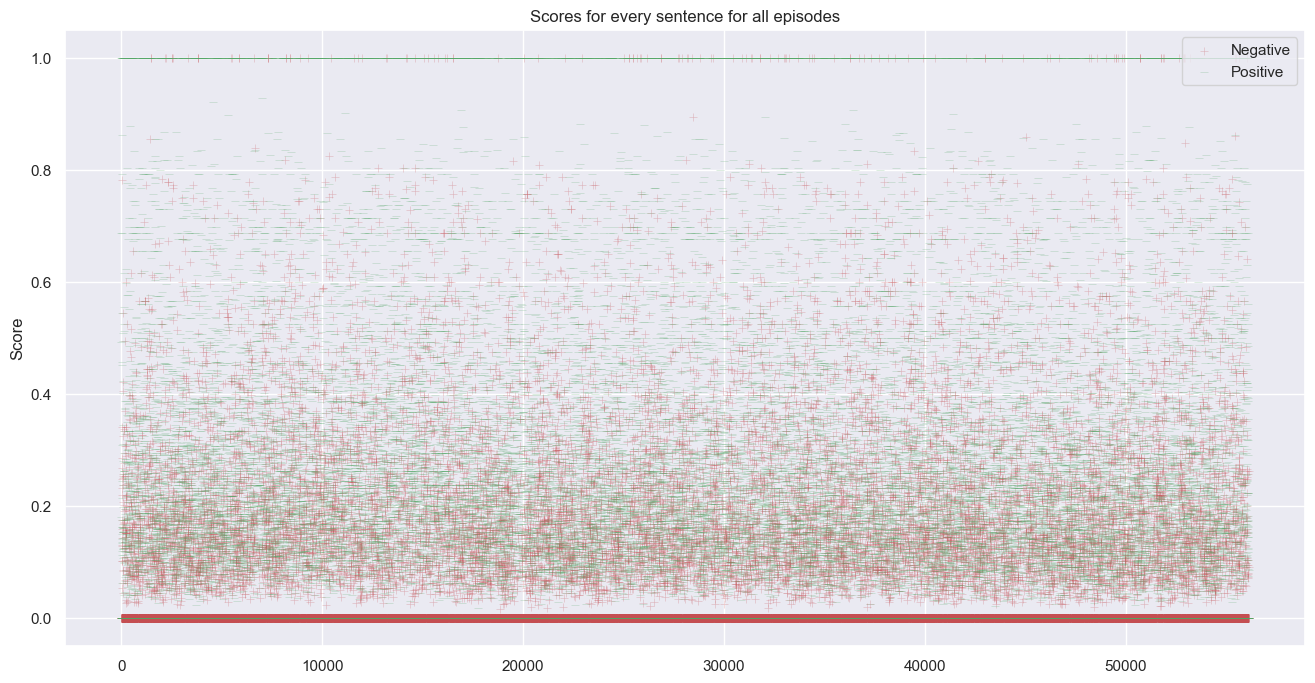

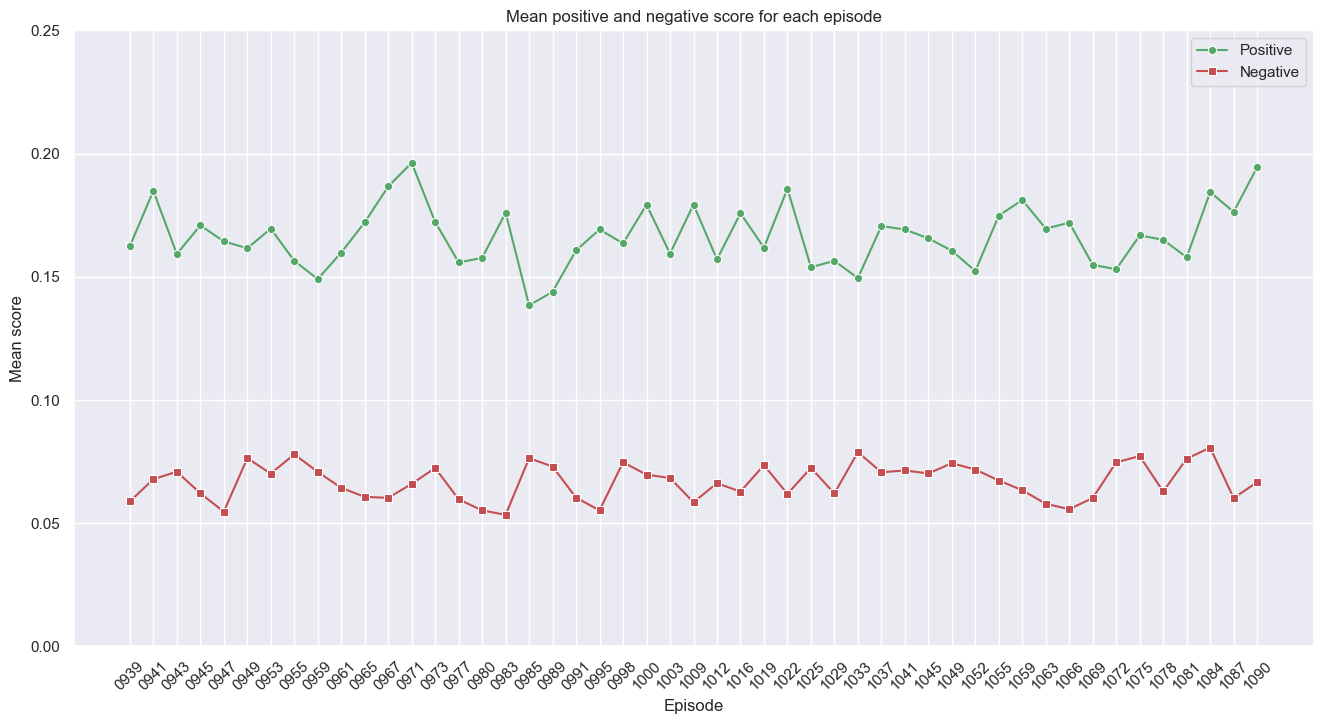

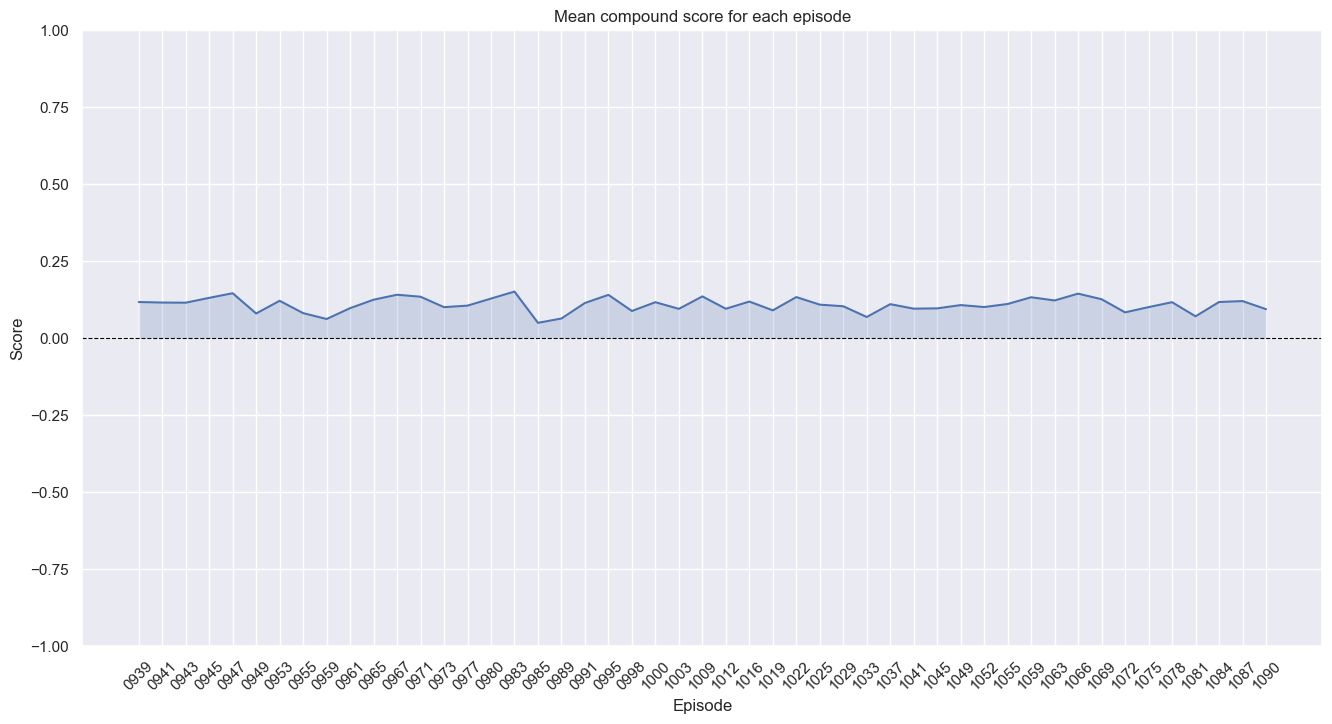

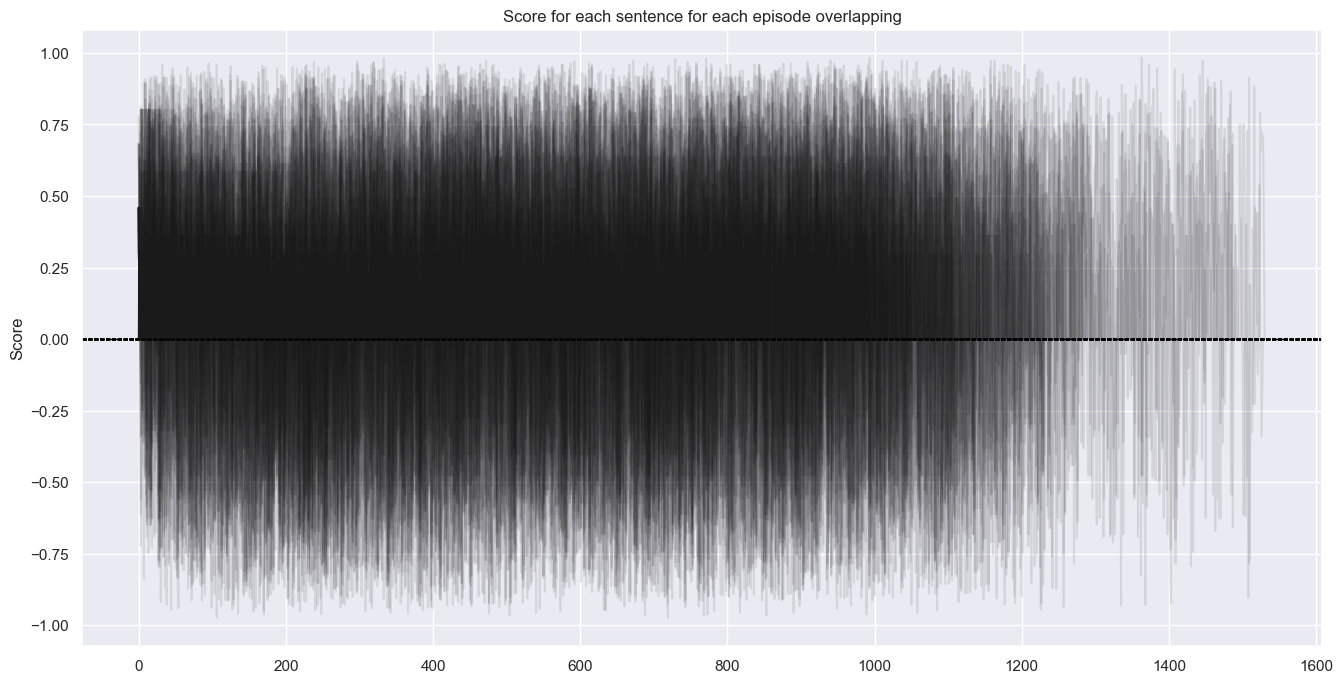

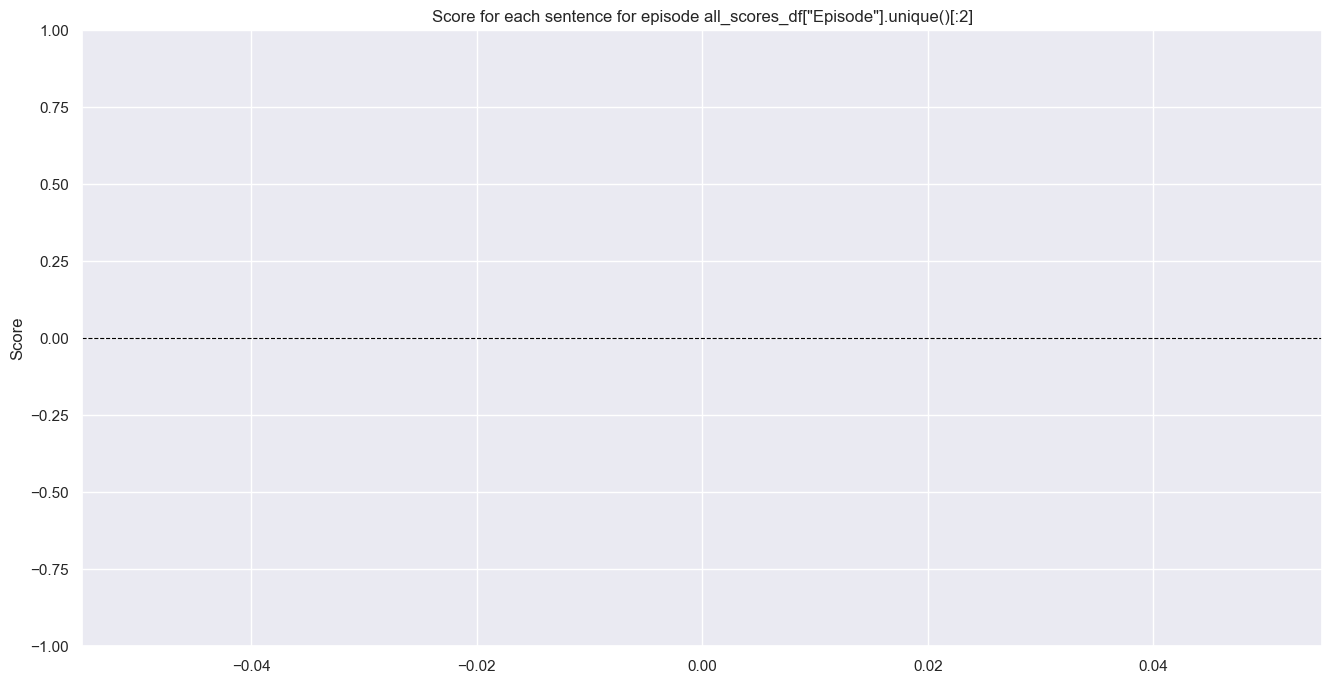

In [155]:
# sfeefaa_n_df = all_scores_df[(all_scores_df.Score_Neg>0) & (all_scores_df.Score_Neg<1)]
# sfeefaa_p_df = all_scores_df[(all_scores_df.Score_Pos>0) & (all_scores_df.Score_Pos<1)]
plt.figure(figsize=(16,8))
plt.title('Scores for every sentence for all episodes')
sns.scatterplot(all_scores_df, x=all_scores_df.index, y='Score_Neg', c='r', alpha=0.3, marker='+', label='Negative')
sns.scatterplot(all_scores_df, x=all_scores_df.index, y='Score_Pos', c='g', alpha=0.3, marker='_', label='Positive')
plt.ylabel('Score')
plt.yticks(np.arange(0,1.01,0.2))
plt.xlabel('')
plt.legend(loc='upper right')
plt.show()

mesfee = all_scores_df.groupby('Episode', as_index=False)[["Score_Pos","Score_Neg","Score_Com"]].mean()
plt.figure(figsize=(16,8))
plt.title('Mean positive and negative score for each episode')
sns.lineplot(mesfee, x='Episode', y='Score_Pos', c='g', marker='o', label='Positive')
sns.lineplot(mesfee, x='Episode', y='Score_Neg', c='r', marker='s', label='Negative')
plt.ylabel('Mean score')
plt.yticks(np.arange(0,0.3,0.05))
plt.xlabel('Episode')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(16,8))
plt.title('Mean compound score for each episode')
plt.plot(mesfee['Episode'], mesfee['Score_Com'])
plt.fill_between(mesfee['Episode'], mesfee['Score_Com'], 0, alpha=0.2)
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Score')
plt.yticks(np.arange(-1,1.01,0.25))
plt.xlabel('Episode')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(16,8))
plt.title(f'Score for each sentence for each episode overlapping')
for episode in all_scores_df["Episode"].unique():
    episode_data = all_scores_df[all_scores_df["Episode"] == episode].reset_index()
    sns.lineplot(data=episode_data, x=episode_data.index, y='Score_Com', c='k', alpha=0.1)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.ylabel('Score')
plt.yticks(np.arange(-1,1.01,0.25))
plt.xlabel('')
plt.show()

for episode in ['all_scores_df["Episode"].unique()[:2]']:
    episode_data = all_scores_df[all_scores_df["Episode"] == episode].reset_index()
    rolling_average = pd.Series(episode_data['Score_Com']).rolling(window=10).mean()
    plt.figure(figsize=(16,8))
    plt.title(f'Score for each sentence for episode {episode}')
    sns.lineplot(episode_data['Score_Com'], alpha=0.3)
    sns.lineplot(rolling_average, c='r')
    plt.fill_between(rolling_average.index, rolling_average, 0, color='r', alpha=0.2)
    plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
    plt.ylabel('Score')
    plt.yticks(np.arange(-1,1.01,0.25))
    plt.xlabel('')
    plt.show()

# LDA

In [159]:
# Use bigrams and trigrams
print(f'Preparing bigrams and trigrams')
bigram = Phrases(all_episodes, min_count=3, threshold=10)
trigram = Phrases(bigram[all_episodes], threshold=10)
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)
all_episodes = [trigram_mod[bigram_mod[episode]] for episode in all_episodes]

# Prepare data for LDA
print(f'Preparing corpus')
dictionary = corpora.Dictionary(all_episodes)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(episode) for episode in all_episodes]

# Train LDA model
print(f'Training LDA model')
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=50, random_state=42)

# Print topics
print("LDA Topics:")
for idx, topic in lda_model.print_topics(-1):
    print(f"Topic {idx+1}: {topic}")
    print()

# Evaluate coherence
coherence_model_lda = CoherenceModel(model=lda_model, texts=all_episodes, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_lda.get_coherence()
print(f"Coherence Score: {coherence_score}")

# Visualise topics
lda_vis = gensimvis.prepare(lda_model, corpus, dictionary)
pyLDAvis.save_html(lda_vis, 'lda_visualisation.html')
print("LDA visualisation saved to 'lda_visualisation.html'")

Preparing bigrams and trigrams
Preparing corpus
Training LDA model
LDA Topics:
Topic 1: 0.004*"cat" + 0.003*"sex" + 0.003*"covid" + 0.002*"communication" + 0.002*"cancer" + 0.002*"feedback" + 0.002*"field" + 0.002*"private" + 0.002*"photo" + 0.002*"pet"

Topic 2: 0.003*"wedding" + 0.002*"father_law" + 0.002*"debt" + 0.002*"sale" + 0.002*"emotion" + 0.002*"dog" + 0.001*"conference" + 0.001*"fly" + 0.001*"bathroom" + 0.001*"photo"

Topic 3: 0.004*"grandparent" + 0.002*"scam" + 0.002*"drink" + 0.002*"staff" + 0.002*"plastic" + 0.002*"dog" + 0.002*"recovery" + 0.002*"chinese" + 0.002*"rage" + 0.002*"gun"

Topic 4: 0.002*"fiance" + 0.002*"grief" + 0.002*"brother_law" + 0.002*"colleague" + 0.002*"scammer" + 0.002*"hospital" + 0.002*"music" + 0.002*"student" + 0.002*"margolis" + 0.002*"military"

Topic 5: 0.004*"card" + 0.003*"friendship" + 0.003*"kevin" + 0.002*"recovery" + 0.002*"christmas" + 0.002*"fbi" + 0.002*"driver" + 0.002*"investment" + 0.002*"fraud" + 0.002*"action"

Coherence Score